<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.py">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [715]:
# ## install required packages
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# # import condacolab
# # condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# # !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [716]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv as OriginalEnv

from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
# from modified_env import StockTradingEnv

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools


<a id='1.4'></a>
## 2.4. Create Folders

In [717]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [718]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [719]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [720]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()





[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)


In [721]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [722]:
df.shape

(97013, 8)

In [723]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470740,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.493416,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090439,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190224,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [724]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (3310, 8)
Successfully added vix


Successfully added turbulence index


In [725]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [726]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.470740,493729600.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,6.470740,6.470740,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,41.493416,5277400.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,41.493416,41.493416,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.090439,6894300.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,33.090439,33.090439,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777546,6186700.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,43.777546,43.777546,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.190224,7325600.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,40.190224,40.190224,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.680597,7906000.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,18.680597,18.680597,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,16.743509,59853700.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,16.743509,16.743509,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,44.988239,10173800.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,44.988239,44.988239,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.843176,13700400.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,27.843176,27.843176,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,135.576187,9135000.0,0.0,0.0,6.492156,6.460513,100.0,66.666667,100.0,135.576187,135.576187,20.040001,0.0


In [727]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [728]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [729]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,377.353851,3779900.0,3.0,-4.283125,412.838061,380.981452,40.895381,-222.793983,41.980385,399.774960,399.273659,23.139999,24.92758
2956,2021-09-30,V,227.580002,228.789993,222.630005,218.542953,7128500.0,3.0,-1.526745,226.859205,214.843808,44.078983,-54.529558,19.569853,223.027285,229.677243,23.139999,24.92758
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,45.622711,18736600.0,3.0,-0.217510,46.664911,45.373698,41.824899,-102.367548,21.682953,46.175153,46.664380,23.139999,24.92758
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,41.084076,6449400.0,3.0,-0.236968,45.359597,40.747569,44.613721,-106.767291,0.941150,42.887238,41.925717,23.139999,24.92758
2956,2021-09-30,WMT,46.880001,47.243332,46.416668,44.720802,22457700.0,3.0,-0.510844,48.019576,44.562556,40.165835,-151.503082,45.479205,46.767856,46.406914,23.139999,24.92758


In [730]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.653519,94639600.0,4.0,-1.694441,154.557868,136.404119,46.927744,-142.221458,41.749873,146.390415,145.492823,21.1,120.030203
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,197.213074,2629400.0,4.0,-2.996547,205.844861,192.892100,40.408552,-96.968262,36.189244,201.697201,210.039146,21.1,120.030203
0,2021-10-01,AXP,168.500000,175.119995,168.479996,167.727448,3956000.0,4.0,2.242076,171.823835,147.181365,56.265098,117.437324,15.667511,158.999403,161.211788,21.1,120.030203
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.030203
0,2021-10-01,CAT,192.899994,195.869995,191.240005,183.514008,3695500.0,4.0,-3.554821,200.903624,177.171292,41.999453,-112.169795,36.203176,192.366892,195.812261,21.1,120.030203


In [731]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [732]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [733]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from risk_controller import RiskController

matplotlib.use("Agg")




class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        # short_term_risk = list[float],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        # self.my_risk_mem = float
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        use_risk_controller = True,

        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration=""
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.use_risk_controller = use_risk_controller
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.short_term_risk = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.risks_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()
        # Parameters for RiskController might include
        self.risk_params = {
            "N": stock_dim,
            "sigma_s_min": 0.01, #0.01,  # Example value
            "sigma_s_max": 0.1, #0.02,  # Example value
            "mu": 2,           # Example value
            "rf": 0.0016,          # Risk-free rate
            "eta": 0.3,         # Example value
            "m": 0.1,            # Minimal impact factor
            "v": 0.5,           # Risk appetite factor
            "market_risk_sigma": 0.05,  # Example market risk
            "active": self.use_risk_controller
        }

        self.risk_controller = RiskController(**self.risk_params)
        self._calculate_daily_returns()

    def _calculate_daily_returns(self):
        """Calculate daily returns based on close prices for each stock."""
        prices = self.df.loc[:, self.tech_indicator_list]  # Assuming close prices are among tech indicators
        returns = prices.pct_change().fillna(0)
        self.df['daily_returns'] = returns.mean(axis=1)  # Storing average daily returns across all stocks
    # def _calculate_daily_returns(self):
    #     """Calculate daily returns based on close prices for each stock and store them individually."""
    #     prices = self.df.loc[:, self.tech_indicator_list]
    #     returns = prices.pct_change().fillna(0)
    #     # Add prefix to distinguish daily return columns
    #     for col in returns.columns:
    #         self.df[f'daily_return_{col}'] = returns[col]


    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):

        # # Calculate daily returns using the latest available data
        # # self._calculate_daily_returns()
        # sigma_s_min = self.risk_params['sigma_s_min']

        # ## RISK CONTROLLER
        # # Extract current prices from the state
        # current_prices = self.state[1:1+self.stock_dim]

        #print(self.df)
        # # Calculate expected returns using the last three daily returns for each stock
        # if 'date' in self.df.columns:
        #     current_date = self.df.loc[self.day, 'date']
        #     past_dates = self.df[self.df['date'] < current_date].tail(3)
        #     expected_returns = np.array([past_dates[f'daily_return_{col}'].mean() for col in self.tech_indicator_list])
        # else:
        #     # If no date column, assume sequential days and use iloc
        #     expected_returns = np.array([self.df[f'daily_return_{col}'].iloc[max(self.day-3, 0):self.day].mean() for col in self.tech_indicator_list])

        # print(self.df[[f'daily_return_{col}' for col in self.tech_indicator_list]].iloc[max(self.day-3, 0):self.day])
        # print(np.array([self.df[f'daily_return_{col}'].mean() for col in self.tech_indicator_list]))

        # Continue with risk parameters and action adjustment
        sigma_s_min = self.risk_params['sigma_s_min']

        ## RISK CONTROLLER
        # Extract current prices from the state
        current_prices = self.state[1:1+self.stock_dim]  # current prices for stocks

        #print("good till here 1")

        # Initialize an empty dictionary to store expected returns for each stock
        expected_returns = {}

        # Loop through each unique stock identifier
        for stock in self.df['tic'].unique():
            # Filter data for the current stock
            stock_data = self.df[self.df['tic'] == stock]
            
            # Sort by date to ensure correct order of days
            stock_data = stock_data.sort_values('date')
            
            # Calculate the mean of the daily returns for the last three available days
            # Here you use iloc to get the last three days' returns
            if len(stock_data) >= 3:
                last_three_returns = stock_data['daily_returns'].iloc[-3:]
                expected_returns[stock] = last_three_returns.mean()
            else:
                # If less than three days of data is available, handle appropriately
                expected_returns[stock] = 0  # or use NaN or any suitable default/fallback value

        # Extracting the expected returns from the dictionary to an array
        expected_returns_array = np.array(list(expected_returns.values()))
        #print("Expected Returns Array:", expected_returns_array)

        expected_returns = expected_returns_array

        # if 'date' in self.df.columns:
        #     current_date = self.df.loc[self.day, 'date']
        #     # Select past dates for each stock
        #     past_dates = self.df[(self.df['date'] < current_date)].tail(3)
        #     # Calculate mean returns for each stock over the last three days
        #     expected_returns = past_dates.groupby('tic')['daily_returns'].mean()
        # if 'date' in self.df.columns:
        #     # current_date = self.df.loc[self.day, 'date']
        #     # Convert to datetime to ensure proper formatting and operations
        #     self.df['date'] = pd.to_datetime(self.df['date'])
            
        #     # Assume 'self.day' is an integer that represents an index in a list of unique days
        #     unique_dates = self.df['date'].drop_duplicates().reset_index(drop=True)
        #     if self.day < len(unique_dates):
        #         current_date = unique_dates[self.day]
        #         print("Current Date:", current_date)
        #     else:
        #         print("Day index out of range")
        #     print(current_date)
        #     past_dates = self.df[self.df['date'] < current_date].tail(3)
        #     print(past_dates)
        #     # Calculate mean even if less than 3 days available
        #     expected_returns = past_dates.groupby('tic')['daily_returns'].mean() if not past_dates.empty else 0
        # else:
        #     # Assuming the DataFrame is already filtered to only include relevant days
        #     expected_returns = self.df.groupby('tic')['daily_returns'].iloc[max(self.day-3, 0):self.day].mean()

        # print("exp returns,", expected_returns)

        # # Calculate expected returns using the last three daily returns for each stock
        # # if 'date' in self.df.columns:
        # #     current_date = self.df.loc[self.day, 'date']
        # #     past_dates = self.df[self.df['date'] < current_date].tail(3)
        # #     expected_returns = past_dates['daily_returns'].mean(axis=0)
        # # else:
        # #     # If no date column, assume sequential days and use iloc
        # #expected_returns = self.df['daily_returns'].iloc[max(self.day-3, 0):self.day].mean()
        # print(self.df['daily_returns'].iloc[max(self.day-3, 0):self.day])
        # print(self.df['daily_returns'].mean(axis=0))

        # Get recent performance from the asset memory
        recent_performance = self.asset_memory[-10:]  # last 10 performances
        sigma_alpha_t=np.std(recent_performance)  # simplistic strategy risk

        sigma_alpha_t_new=np.linalg.norm((np.dot(np.diag(current_prices) , actions)),2)  # simplistic strategy risk

        # print ("diag of current prices shape (sigma k t1)", np.diag(current_prices).shape)
        # print ("actions shape", actions.shape)
        # print ("sigma alpha t old ", sigma_alpha_t)
        # print ("sigma alpha t old shape", sigma_alpha_t)
        # print ("sigma alpha t old type", type(sigma_alpha_t))


        # print ("sigma alpha t new ", sigma_alpha_t_new)
        # print ("sigma alpha t new type", type(sigma_alpha_t_new))
        # print ("sigma alpha t new shape", sigma_alpha_t.shape)
        # print ("np.diag(current_prices) * actions",np.diag(current_prices) * actions)

        # print(sigma_alpha_t,sigma_alpha_t_new)
        actions_original = actions  # Store original actions for comparison
        #print("action sum", np.sum(actions))

        #print("good till here")
        # Adjust actions using the RiskController
        actions = self.risk_controller.adjust_actions(
            a_rl=actions,
            delta_p_t1=expected_returns,  # this is an array if multiple stocks
            sigma_k_t1=np.diag(current_prices),  # simplistic sigma calculaon
            # sigma_alpha_t=np.std(recent_performance),  # simplistic strategy risk
            # sigma_alpha_t=np.linalg.norm(np.diag(current_prices) * actions),  # simplistic strategy risk
            sigma_alpha_t=sigma_alpha_t_new,  # simplistic strategy risk

            sigma_s_t=sigma_s_min,  # example static risk setting
            recent_performance=recent_performance
        )

        #risk sigma_alpha_t = is norm(sigma_k_t_1 * a_rl )



        # print("Market Risk: ", np.std(recent_performance)+self.risk_params["market_risk_sigma"])
        # sigma_s_min = self.risk_params['sigma_s_min']

        # ## RISK CONTROLLER 
        # # Example to calculate necessary parameters for risk adjustment
        # current_prices = self.state[1:1+self.stock_dim]  # current prices for stocks
        # #expected_returns = self.df.loc[self.day+1, 'expected_return'] if self.day+1 < len(self.df) else 0
        # expected_returns = self.df['daily_returns'].iloc[max(self.day-3, 0):self.day].mean()
        # #print("here")
        # recent_performance = self.asset_memory[-10:]  # last 10 performances

        # actions_original = actions

        # # Adjust actions using the RiskController
        # actions = self.risk_controller.adjust_actions(
        #     a_rl=actions,
        #     delta_p_t1=expected_returns,  # this is an array if multiple stocks
        #     sigma_k_t1=np.diag(current_prices),  # simplistic sigma calculation
        #     sigma_alpha_t=np.std(recent_performance),  # simplistic strategy risk
        #     sigma_s_t=sigma_s_min, #self.risk_params['sigma_s_min'],  # example static risk setting
        #     recent_performance=recent_performance
        # )
        
        #print("action diff:", actions_original - actions)
        
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            #DURING PREDICTION?
            print("risk memory:",len(self.risks_memory))
            print (self.risks_memory)
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]

            df_risks = pd.DataFrame(self.risks_memory)
            df_risks.columns = ["short_term_risk"]
            df_risks["date"] = self.date_memory[:-1]


            if self.episode % self.print_verbosity == 0:
                
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                # print(f"short term risk: {self.r}")

                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_risks.to_csv(
                    "results/account_risks_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.risks_memory, "r")
                plt.savefig(
                    "results/risk_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()


                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares

            #print("integer actions", actions)
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

            #CALCULATE AND LOG SHORT TERM RISK FOR PLOTTING

            # sigma_a_t=np.linalg.norm((np.dot(np.diag(current_prices) , actions)),2),  # simplistic strategy risk
            # sigma_a_t=np.std(recent_performance) 
            self.short_term_risk = sigma_alpha_t_new+self.risk_params["market_risk_sigma"]
            self.risks_memory.append(self.short_term_risk)

            # if len(self.risks_memory) == len(self.asset_memory):
            #     self.risks_memory = []


            # print ("risk memory",self.risks_memory)


            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        # self.risks_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory



        # df_risks.to_csv(
        #     "results/account_risks_{}_{}_{}.csv".format(
        #         self.mode, self.model_name, self.iteration
        #     ),
        #     index=False,
        # )

        # print(len(date_list))
        #MAYBE WE CAN SAVE AS AN EXTRA COLUMN IN ASSET MEMORY?

        print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )

        # df_account_value = pd.DataFrame(
        #     {"date": date_list, "account_value": asset_list, "short_term_risk": risk_list}
        # )

        
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    

    def get_risk_mem(self):
        # risk_list = self.risks_memory

        df_risks = pd.DataFrame(self.risks_memory)
        df_risks.columns = ["short_term_risk"]
        df_risks["date"] = self.date_memory[:-1]
        self.risks_memory = []
        return df_risks



In [734]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "make_plots": True 
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
e_train__og_gym = OriginalEnv(df = train, **env_kwargs)

Risk Controller Active: True


## Environment for Training



In [735]:
env_train, _ = e_train_gym.get_sb_env() #uses risk controller
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [736]:
env_train_og, _ = e_train__og_gym.get_sb_env() # No Risk Controller
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [737]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1a: A2C with Risk Controller


In [738]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
  # Save the trained model
  model_a2c.save(RESULTS_DIR + '/a2c/trained_model_a2c.zip')



{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [739]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                              tb_log_name='a2c',
#                              total_timesteps=1000) if if_using_a2c else None
try:
    trained_a2c = agent.train_model(
        model=model_a2c, 
        tb_log_name='a2c',
        total_timesteps=100 #,
        #verbose=True  # Increase verbosity to get more info on errors
    ) if if_using_a2c else None
except Exception as e:
    print("Failed to train due to:", e)
    # Optional: Try a different configuration or handle the failure



# print(e_train_gym.get_risk_mem())



---------------------------------------
| time/                 |             |
|    fps                | 9           |
|    iterations         | 100         |
|    time_elapsed       | 53          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | -0.768      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -56.1       |
|    reward             | -0.25921527 |
|    std                | 1.01        |
|    value_loss         | 2.32        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 9          |
|    iterations         | 200        |
|    time_elapsed       | 102        |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.5      |
|    explained_variance | 0          |
|    lear

In [740]:
# print(e_train_gym.get_risk_mem())

# df_risk_a2c_rc = e_train_gym.get_risk_mem().set_index(e_train_gym.get_risk_mem().columns[0])



# result = df_risk_a2c_rc
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();

# result.plot();


### Agent 1b: A2C with no Risk Controller



In [741]:
agent = DRLAgent(env = env_train_og)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
  # Save the trained model
  model_a2c.save(RESULTS_DIR + '/a2c/trained_model_a2c_no_rc.zip')



{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [742]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                              tb_log_name='a2c',
#                              total_timesteps=1000) if if_using_a2c else None
try:
    trained_a2c_no_rc = agent.train_model(
        model=model_a2c, 
        tb_log_name='a2c',
        total_timesteps=100 #,
        #verbose=True  # Increase verbosity to get more info on errors
    ) if if_using_a2c else None
except Exception as e:
    print("Failed to train due to:", e)
    # Optional: Try a different configuration or handle the failure
    


---------------------------------------
| time/                 |             |
|    fps                | 214         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 0.0368      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -56.7       |
|    reward             | -0.17288357 |
|    std                | 1.01        |
|    value_loss         | 2.65        |
---------------------------------------


-------------------------------------
| time/                 |           |
|    fps                | 231       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -12       |
|    reward             | 0.6584669 |
|    std                | 1.01      |
|    value_loss         | 1.57      |
-------------------------------------


### Agent 2: DDPG

In [743]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)
  # Save the trained model
  model_ddpg.save(tmp_path + '/trained_model_ddpg.zip')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [744]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=5000) if if_using_ddpg else None

### Agent 3: PPO

In [745]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)
  # Save the trained model
  model_ppo.save(tmp_path + '/trained_model_ppo.zip')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [746]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=5000) if if_using_ppo else None

### Agent 4: TD3

In [747]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS) #do not fine tune pretrained model!

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)
  # Save the trained model
  model_td3.save(tmp_path + '/trained_model_td3.zip')

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [748]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=5000) if if_using_td3 else None

### Agent 5a: SAC with Risk Controller

In [749]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
  # Save the trained model
  model_sac.save(tmp_path + '/trained_model_sac.zip')



  

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [750]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50) if if_using_sac else None

### Agent 5b: SAC with no Risk Controller

In [751]:
agent = DRLAgent(env = env_train_og)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 100000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
  # Save the trained model
  model_sac.save(tmp_path + '/trained_model_sac_no_rc.zip')
  

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [752]:
trained_sac_no_rc = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [753]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [754]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [755]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [756]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139712
std        43.880927
min         0.000000
25%        14.608561
50%        23.649859
75%        38.399076
max       652.617079
Name: turbulence, dtype: float64

In [757]:
insample_risk_indicator.turbulence.quantile(0.996)

291.73724285986975

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [758]:
#from FINRL tutorial:
# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140

# e_trade_gym = StockTradingEnv(df = trade,turbulence_threshold = 100, risk_indicator_col='vix', **env_kwargs) # 
e_trade_gym = StockTradingEnv(df = trade,turbulence_threshold = None, use_risk_controller = True, risk_indicator_col='vix', **env_kwargs) # 
e_trade_gym_og = StockTradingEnv(df = trade,turbulence_threshold = None, use_risk_controller = False, risk_indicator_col='vix', **env_kwargs) # 

# env_trade, obs_trade = e_trade_gym.get_sb_env()

#SETTING THE turbulence to 0 will cause issues

#is the trading gym a different, more rewarding environment than the other environment?
#do we have consistency?


# e_trade_gym_og = OriginalEnv(df = trade,turbulence_threshold = None, risk_indicator_col='vix', **env_kwargs) # 


Risk Controller Active: True
Risk Controller Active: False


In [759]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,daily_returns
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.653519,94639600.0,4.0,-1.694441,154.557868,136.404119,46.927744,-142.221458,41.749873,146.390415,145.492823,21.1,120.030203,0.000000
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,197.213074,2629400.0,4.0,-2.996547,205.844861,192.892100,40.408552,-96.968262,36.189244,201.697201,210.039146,21.1,120.030203,0.218194
0,2021-10-01,AXP,168.500000,175.119995,168.479996,167.727448,3956000.0,4.0,2.242076,171.823835,147.181365,56.265098,117.437324,15.667511,158.999403,161.211788,21.1,120.030203,-0.622548
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.030203,-0.021639
0,2021-10-01,CAT,192.899994,195.869995,191.240005,183.514008,3695500.0,4.0,-3.554821,200.903624,177.171292,41.999453,-112.169795,36.203176,192.366892,195.812261,21.1,120.030203,1.044765


In [760]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)


# print (df_account_value_a2c)

# e_trade_gym.risks_memory = []

353
risk memory: 352
[600.0223521657501, 595.9415649170064, 600.0071410025839, 601.4494033772883, 608.1174871755674, 606.8134036845631, 582.3924573443475, 152.14562624722, 105.83562549726969, 99.96189295835859, 125.1795780802156, 132.2280812189631, 147.8524664254425, 148.11126802299665, 119.25804813381467, 139.63234574636843, 140.43570747441495, 139.8981789185932, 133.6503053551364, 131.28694850240203, 132.62418878357786, 137.03088279634028, 136.46850869504686, 225.65190691495837, 226.85395450303065, 228.19584140142652, 191.60575382796563, 141.90464830203123, 162.98558755422124, 136.325034769412, 134.79931402078668, 154.1988143061383, 157.54286815790712, 166.77124043452233, 168.5200870864956, 128.34793411668292, 107.80752820907026, 108.13303685197954, 109.23531620103597, 137.89906065547262, 188.43886866912072, 139.43113601072434, 205.71496299778252, 168.20872222096594, 167.57132210699544, 127.65209641407365, 108.78824049102184, 108.38075426736239, 107.1154290698445, 102.44412154662604,

In [761]:
print(e_trade_gym.risks_memory)

# print(e_trade_gym.get_risk_mem())

#WHY EMPTY?


# df_risk_a2c_rc = e_trade_gym.get_risk_mem().set_index(e_trade_gym.get_risk_mem().columns[0])
risk_a2c_rc = e_trade_gym.risks_memory
risk_a2c_rc_norm = (risk_a2c_rc-np.min(risk_a2c_rc))/(np.max(risk_a2c_rc)-np.min(risk_a2c_rc))


# result = risk_a2c_rc
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();

# plt.plot(risk_a2c_rc )
e_trade_gym.risks_memory = []

[600.0223521657501, 595.9415649170064, 600.0071410025839, 601.4494033772883, 608.1174871755674, 606.8134036845631, 582.3924573443475, 152.14562624722, 105.83562549726969, 99.96189295835859, 125.1795780802156, 132.2280812189631, 147.8524664254425, 148.11126802299665, 119.25804813381467, 139.63234574636843, 140.43570747441495, 139.8981789185932, 133.6503053551364, 131.28694850240203, 132.62418878357786, 137.03088279634028, 136.46850869504686, 225.65190691495837, 226.85395450303065, 228.19584140142652, 191.60575382796563, 141.90464830203123, 162.98558755422124, 136.325034769412, 134.79931402078668, 154.1988143061383, 157.54286815790712, 166.77124043452233, 168.5200870864956, 128.34793411668292, 107.80752820907026, 108.13303685197954, 109.23531620103597, 137.89906065547262, 188.43886866912072, 139.43113601072434, 205.71496299778252, 168.20872222096594, 167.57132210699544, 127.65209641407365, 108.78824049102184, 108.38075426736239, 107.1154290698445, 102.44412154662604, 102.12718563114593, 

In [762]:
trained_moedl = trained_a2c_no_rc
df_account_value_a2c_no_rc, df_actions_a2c_no_rc = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym_og)
#Train and trade for original RL is in unmodified env


353
risk memory: 352
[741.7892540588385, 734.6951363251218, 742.6930443471012, 745.7597224726728, 754.8960596562973, 755.972134755314, 750.8461876460094, 748.6545813081224, 744.030717151398, 709.9545408933171, 171.53635365863127, 214.1543018367888, 177.44300932953539, 203.66304877402013, 231.15553440731435, 174.34537092204116, 174.8705645649328, 240.64939974669383, 244.46895677320018, 251.0033244970791, 218.98988676941235, 219.4902581669625, 234.1067084239517, 235.18069225918728, 236.35852645344386, 239.6722625767631, 225.32139308829093, 238.551531893955, 251.7317925531922, 249.27235775716406, 251.41146882742382, 236.28470163248258, 229.90346092066636, 227.04530953826307, 168.6557859648863, 234.99943853204684, 242.782826140302, 256.3921711966, 240.7489208928374, 240.81440504669837, 242.76510632196064, 222.15234597616282, 232.7337905899535, 218.28921813588576, 236.99025086046544, 209.91345125574932, 190.94022581204499, 205.22760594757443, 205.14431686580684, 191.41175462533116, 198.6710

In [763]:
print(e_trade_gym_og.risks_memory)

# print(e_trade_gym.get_risk_mem())

#WHY EMPTY?


# df_risk_a2c_rc = e_trade_gym.get_risk_mem().set_index(e_trade_gym.get_risk_mem().columns[0])
risk_a2c_no_rc = e_trade_gym_og.risks_memory
risk_a2c_no_rc_norm = (risk_a2c_no_rc-np.min(risk_a2c_no_rc))/(np.max(risk_a2c_no_rc)-np.min(risk_a2c_no_rc))

# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();

# plt.plot(risk_a2c_no_rc )
e_trade_gym_og.risks_memory = []

[741.7892540588385, 734.6951363251218, 742.6930443471012, 745.7597224726728, 754.8960596562973, 755.972134755314, 750.8461876460094, 748.6545813081224, 744.030717151398, 709.9545408933171, 171.53635365863127, 214.1543018367888, 177.44300932953539, 203.66304877402013, 231.15553440731435, 174.34537092204116, 174.8705645649328, 240.64939974669383, 244.46895677320018, 251.0033244970791, 218.98988676941235, 219.4902581669625, 234.1067084239517, 235.18069225918728, 236.35852645344386, 239.6722625767631, 225.32139308829093, 238.551531893955, 251.7317925531922, 249.27235775716406, 251.41146882742382, 236.28470163248258, 229.90346092066636, 227.04530953826307, 168.6557859648863, 234.99943853204684, 242.782826140302, 256.3921711966, 240.7489208928374, 240.81440504669837, 242.76510632196064, 222.15234597616282, 232.7337905899535, 218.28921813588576, 236.99025086046544, 209.91345125574932, 190.94022581204499, 205.22760594757443, 205.14431686580684, 191.41175462533116, 198.6710413561002, 205.661863

In [764]:
# trained_moedl = trained_ddpg
# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_moedl, 
#     environment = e_trade_gym)

In [765]:
# trained_moedl = trained_ppo
# df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=trained_moedl, 
#     environment = e_trade_gym)

In [766]:
# trained_moedl = trained_td3
# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_moedl, 
#     environment = e_trade_gym)

In [767]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)



353
risk memory: 352
[1016.1381693647438, 1004.4555160802552, 1016.0439180752285, 1020.5579986420512, 1031.917137851453, 1031.1000494798623, 1020.4901296320684, 1018.6979512298088, 1020.1377006340621, 1036.4990884239087, 1046.0995072041353, 1055.5714585570079, 1056.9323437279238, 1050.5187753418595, 1061.4678886267923, 1063.7544277115712, 1066.605291159278, 1056.100079125284, 1056.4305019234087, 1058.3240338778023, 1064.1552803721138, 1069.608003623606, 1080.0072951305804, 1088.100750426111, 1085.1954766123492, 1092.6371997618135, 1097.3945637621487, 1094.2190989852206, 1082.619831684923, 1082.4165561870504, 1089.437762238104, 1087.0323052213405, 1077.791329592381, 1083.5767827071045, 1088.4417112310102, 1080.811018186102, 1079.3474754371323, 1083.6992295687896, 1080.8578921686567, 1046.5764621288863, 1066.172751331513, 1040.7859691632666, 1028.647691900027, 1050.4943199151521, 1045.540890679182, 1070.2125223729402, 1078.4715779312933, 1089.5147600706741, 1091.5365327460688, 1097.58753

In [768]:
print(e_trade_gym.risks_memory)

# print(e_trade_gym.get_risk_mem())

#WHY EMPTY?


# df_risk_a2c_rc = e_trade_gym.get_risk_mem().set_index(e_trade_gym.get_risk_mem().columns[0])
risk_sac_rc = e_trade_gym.risks_memory


# result = risk_a2c_rc
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();

# plt.plot(risk_a2c_rc )
e_trade_gym.risks_memory = []

[1016.1381693647438, 1004.4555160802552, 1016.0439180752285, 1020.5579986420512, 1031.917137851453, 1031.1000494798623, 1020.4901296320684, 1018.6979512298088, 1020.1377006340621, 1036.4990884239087, 1046.0995072041353, 1055.5714585570079, 1056.9323437279238, 1050.5187753418595, 1061.4678886267923, 1063.7544277115712, 1066.605291159278, 1056.100079125284, 1056.4305019234087, 1058.3240338778023, 1064.1552803721138, 1069.608003623606, 1080.0072951305804, 1088.100750426111, 1085.1954766123492, 1092.6371997618135, 1097.3945637621487, 1094.2190989852206, 1082.619831684923, 1082.4165561870504, 1089.437762238104, 1087.0323052213405, 1077.791329592381, 1083.5767827071045, 1088.4417112310102, 1080.811018186102, 1079.3474754371323, 1083.6992295687896, 1080.8578921686567, 1046.5764621288863, 1066.172751331513, 1040.7859691632666, 1028.647691900027, 1050.4943199151521, 1045.540890679182, 1070.2125223729402, 1078.4715779312933, 1089.5147600706741, 1091.5365327460688, 1097.587539507029, 1078.5508396

In [769]:
trained_moedl = trained_sac_no_rc
df_account_value_sac_no_rc, df_actions_sac_no_rc = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym_og)

353
risk memory: 352
[1016.1381693647438, 1004.4555160802552, 1016.0439180752285, 1020.5579986420512, 1031.917137851453, 1032.1442124900773, 1016.7957115836185, 1021.8043981932826, 1022.5293506212295, 1017.3922477690269, 1042.4805591173301, 1026.65677515057, 1046.7225545153663, 1038.0385046056965, 1035.8219658063365, 1071.02965526124, 1073.7245510799307, 1050.7651531078723, 1063.0939863829724, 1055.4218727788086, 1062.041164485319, 1070.3845818817028, 1068.7278606731918, 1082.163294776026, 1039.1298365724301, 1092.0728162576725, 1097.9502777736677, 1094.7531481947178, 1084.2499755320446, 1043.7458001195557, 1046.7055028803616, 1083.9055778614336, 1092.4220998198407, 1084.180647867303, 1045.0831639696196, 1076.9623871014649, 1079.421338529669, 1086.2582537832948, 1086.0745356355078, 1054.6543909510929, 1065.7965389431665, 1007.935358736496, 970.7702598044657, 1053.2941916468308, 1051.808783954045, 1072.7099404909452, 1090.2324139842954, 1090.9222343648657, 1091.8668542903642, 1098.88590

In [770]:
print(e_trade_gym_og.risks_memory)

# print(e_trade_gym.get_risk_mem())

#WHY EMPTY?


# df_risk_a2c_rc = e_trade_gym.get_risk_mem().set_index(e_trade_gym.get_risk_mem().columns[0])
risk_sac_no_rc = e_trade_gym_og.risks_memory


# result = risk_a2c_rc
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();

# plt.plot(risk_a2c_rc )
e_trade_gym_og.risks_memory = []

[1016.1381693647438, 1004.4555160802552, 1016.0439180752285, 1020.5579986420512, 1031.917137851453, 1032.1442124900773, 1016.7957115836185, 1021.8043981932826, 1022.5293506212295, 1017.3922477690269, 1042.4805591173301, 1026.65677515057, 1046.7225545153663, 1038.0385046056965, 1035.8219658063365, 1071.02965526124, 1073.7245510799307, 1050.7651531078723, 1063.0939863829724, 1055.4218727788086, 1062.041164485319, 1070.3845818817028, 1068.7278606731918, 1082.163294776026, 1039.1298365724301, 1092.0728162576725, 1097.9502777736677, 1094.7531481947178, 1084.2499755320446, 1043.7458001195557, 1046.7055028803616, 1083.9055778614336, 1092.4220998198407, 1084.180647867303, 1045.0831639696196, 1076.9623871014649, 1079.421338529669, 1086.2582537832948, 1086.0745356355078, 1054.6543909510929, 1065.7965389431665, 1007.935358736496, 970.7702598044657, 1053.2941916468308, 1051.808783954045, 1072.7099404909452, 1090.2324139842954, 1090.9222343648657, 1091.8668542903642, 1098.8859089710745, 1087.747287

In [771]:
df_account_value_a2c.shape

(353, 2)

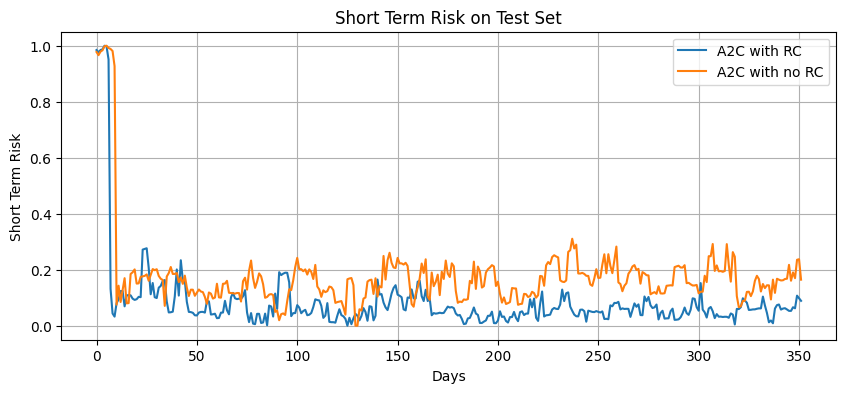

In [772]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,4)
plt.figure();
plt.ylabel('Short Term Risk')
plt.xlabel('Days')
plt.title('Short Term Risk on Test Set')
plt.plot(risk_a2c_rc_norm, label = "A2C with RC" )
plt.plot(risk_a2c_no_rc_norm, label = "A2C with no RC" )
# plt.plot(risk_sac_rc, label = "SAC with RC" )
# plt.plot(risk_sac_no_rc, label = "SAC with no RC" )
plt.legend() 
plt.grid()
plt.show()



<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [773]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.470740
1,2010-01-04,AMGN,41.493416
2,2010-01-04,AXP,33.090439
3,2010-01-04,BA,43.777546
4,2010-01-04,CAT,40.190224


In [774]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [775]:
mvo.shape[0]

3310

### Helper functions

In [776]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [777]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [778]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[147.23 , 192.382, 174.921, ...,  45.37 ,  42.184,  47.727],
       [146.767, 190.446, 172.098, ...,  44.985,  41.145,  47.336],
       [150.435, 190.99 , 168.792, ...,  45.13 ,  41.128,  47.631],
       ...,
       [148.607, 229.888, 172.095, ...,  35.282,  33.843,  46.493],
       [145.931, 226.057, 171.22 , ...,  35.474,  33.46 ,  46.618],
       [147.135, 226.821, 170.287, ...,  35.602,  33.077,  46.281]])

In [779]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.048 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [780]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [781]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,146.559692,191.414337,176.235519,212.869995,192.009811,293.53656,51.054253,103.400597,171.451218,386.877563,...,75.759415,301.476562,159.543274,132.339661,153.064957,434.091156,229.462738,44.942253,42.978924,48.147533


In [782]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1832.086,    0.   ,    0.   ,    0.   ,    0.   ,  228.83 ,
          0.   ,    0.   ,    0.   ,    0.   ,  941.753,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  503.5  ,    0.   ,    0.   ,
        575.732,   24.274,    0.   ,    0.   ,    0.   ])

In [783]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120102e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [784]:
df_account_value_a2c.head()


,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.987565e+05
2,2021-10-05,9.997676e+05
3,2021-10-06,1.000075e+06
4,2021-10-07,1.006097e+06


In [785]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c_no_rc = df_account_value_a2c_no_rc.set_index(df_account_value_a2c_no_rc.columns[0])


#df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
#df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
#df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac_no_rc = df_account_value_sac_no_rc.set_index(df_account_value_sac_no_rc.columns[0])


# df_result_a2c.head()

df_account_value_a2c.to_csv("df_account_value_a2c.csv")

# df_risks = pd.read_csv(StockFileName,  nrows= Rows)


#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

#result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True, suffixes=('_a2c', '_ddpg'))
result = df_result_a2c
result = pd.merge(result, df_result_a2c_no_rc, left_index=True, right_index=True, suffixes=('', '_a2c'))

#result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('', '_ppo'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True, suffixes=('', '_sac'))
result = pd.merge(result, df_result_sac_no_rc, left_index=True, right_index=True, suffixes=('', '_sac'))

result = pd.merge(result, MVO_result, left_index=True, right_index=True, suffixes=('', '_mvo'))
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
#result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']
result.columns = ['a2c_with_rc','a2c_no_rc', 'sac_with_rc','sac_no_rc', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:               a2c_with_rc     a2c_no_rc    sac_with_rc     sac_no_rc  \
2021-10-26  1.024010e+06  1.046747e+06  987274.485877  1.008374e+06   
2021-10-27  1.012330e+06  1.043759e+06  978515.011786  9.965850e+05   
2021-10-28  1.021637e+06  1.055055e+06  985002.039958  9.981401e+05   
2021-10-29  1.022595e+06  1.058402e+06  984813.628634  9.981397e+05   
2021-11-01  1.027498e+06  1.057545e+06  997476.387437  1.002797e+06   
...                  ...           ...            ...       

In [786]:
df_result_a2c.head()


,account_value
date,
2021-10-01,1.000000e+06
2021-10-04,9.987565e+05
2021-10-05,9.997676e+05
2021-10-06,1.000075e+06
2021-10-07,1.006097e+06


Text(0.5, 1.0, 'Performance on Test Set')

<Figure size 1500x500 with 0 Axes>

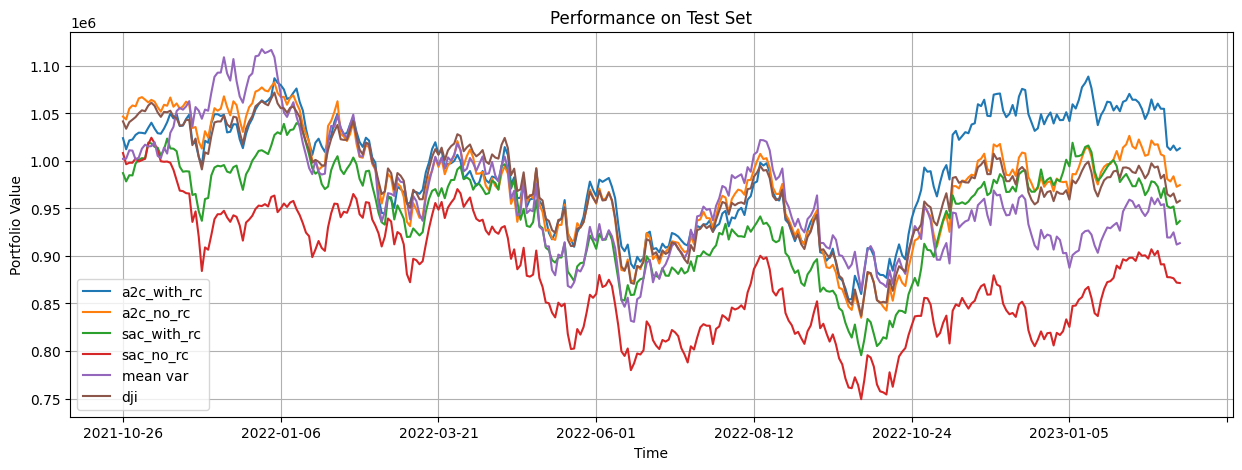

In [787]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();

result.plot();
plt.grid();
plt.ylabel('Portfolio Value')
plt.xlabel('Time')
plt.title('Performance on Test Set')

In [788]:
#todo: Plot short term risk
#we have 

# df_risks = pd.read_csv(StockFileName,  nrows= Rows)
